In [1]:
#############load necessary libraries##############

import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
import scanpy.external as sce
import seaborn as sns
import re

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc_params
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#import matplotlib.colors



pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
sc.set_figure_params(dpi = 150, dpi_save = 150, format = 'png')
sc._settings.ScanpyConfig(verbosity=0)

scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

np.random.seed(44)

In [2]:
#############define necessary functions##############

def Get_genes_to_keep(loaded_obj):
    detected_genes = loaded_obj[:,sc.pp.filter_genes(loaded_obj, min_cells=3, 
                                                     inplace=False)[0]].var_names.tolist()
    MitoRiboGenes = (list(filter(lambda x: re.search(r'^Mt-', x, re.IGNORECASE), detected_genes)) + 
                     list(filter(lambda x: re.search(r'^Mtrnr', x, re.IGNORECASE), detected_genes)) + 
                     list(filter(lambda x: re.search(r'^Rpl', x, re.IGNORECASE), detected_genes)) +
                     # "^RP[0-5][0-9]" catches a lot of non ribosomal proteins like LINCs, Pseudogenes and even prot coding genes
                     #list(filter(lambda x: re.search(r'^RP[0-5][0-9]', x, re.IGNORECASE), detected_genes)) +
                     list(filter(lambda x: re.search(r'^Rps', x, re.IGNORECASE), detected_genes)))
    return(list(set(detected_genes) - set(MitoRiboGenes)))


def PreProcessing(obj, QCplots=False, Verbosity="high"):
    obj = obj
  
    if QCplots:
        sc.pl.violin(obj, ['percent_mito', 'percent_ribo', 'n_counts'], jitter=0.4, multi_panel=True)

    # first round of gene filtering
    Genes_to_keep = Get_genes_to_keep(obj)
    obj = obj[:,Genes_to_keep]
    if Verbosity=="high":
        print("First gene filtering: "+str(obj.X.shape))

    # Cells filtering
    sc.pp.filter_cells(obj, min_genes=200)
    median_genes_per_cell = np.median(obj.X.getnnz(axis=1)) # recomputing this per each dataset will introduce inconsistent thrholds
    sc.pp.filter_cells(obj, max_genes=2.5*median_genes_per_cell)
    if Verbosity=="high":
        print("Cell filtering: "+str(obj.X.shape))

    # Second round of gene filtering: some genes got to all-zeros after cell filtering
    Genes_to_keep_2 = Get_genes_to_keep(obj)
    obj = obj[:,Genes_to_keep_2]
    if Verbosity=="high":
        print("Second gene filtering: "+str(obj.X.shape))

    obj = obj
    if QCplots:
        sc.pl.violin(obj, ['percent_mito', 'percent_ribo', 
                           'n_counts', 'n_genes'], jitter=0.4, multi_panel=True)

    if Verbosity=="high":
        print("Raw!")
        #print(obj.X[:10,:10])

    sc.pp.normalize_total(obj)
    if Verbosity=="high":
        print("Normalized")
        #print(obj.X[:10,:10])

    sc.pp.log1p(obj)
    if Verbosity=="high":
        print("Log transformed")
        #print(obj.X[:10,:10])

    sc.pp.highly_variable_genes(obj) # needs log transformed data
    if QCplots:
        sc.pl.highly_variable_genes(obj)
    #if Verbosity=="high":
        #print("HVG subset: "+str(obj.shape))
    
    return(obj)


# PROVIDE CELL CYCLE GENE LISTS FOR PHASE SCORING
S_genes_file = "/home/kgr851/new_analysis_new_cc/cc/s.txt"
G2M_genes_file = "/home/kgr851/new_analysis_new_cc/cc/g2m.txt"
S_phase_genes = [x.strip() for x in open(S_genes_file)]
G2M_phase_genes = [x.strip() for x in open(S_genes_file)]

def CellCycleRegression(obj):
    
    # N.B. Regression is only performed on matrix .X
    
        print("Regressing individual phases")
        sc.pp.scale(obj)
        sc.tl.score_genes_cell_cycle(obj, s_genes=S_phase_genes, g2m_genes=G2M_phase_genes)
        sc.pp.regress_out(obj, ['S_score', 'G2M_score'])
        sc.pp.scale(obj)
        # Store "old_phase" for later plotting of regression effect on phase%
        obj.obs['OldPhase'] = obj.obs['phase']
        sc.tl.score_genes_cell_cycle(obj, s_genes=S_phase_genes, g2m_genes=G2M_phase_genes)
        print("Regressed")
        print(obj.X[:10,:10])
   
        return(obj)

def subset_two_genes2(adata, gene1: str ,gene2: str, coexpressed: bool = False):
    gene1_cells = adata[adata[: , gene1].X > 0.8, :].obs_names
    gene2_cells = adata[adata[: , gene2].X > 0.8, :].obs_names
    
    if coexpressed:
        cells = np.intersect1d(gene1_cells, gene2_cells)
    else:
         cells = np.unique(np.concatenate([gene1_cells, gene2_cells]))
    
    return adata[cells, ].copy()

# def subset_two_genes(adata, gene1: str ,gene2: str):
#     x = adata[adata[: , gene1].X > 0.75, :]
#     y = adata[adata[: , gene2].X > 0.75, :]
#     common_obs = np.intersect1d(x.obs_names, y.obs_names)
#     mix = adata[common_obs]
#     x = x[~x.obs_names.isin(common_obs)].copy()
#     y = y[~y.obs_names.isin(common_obs)].copy()
    
# print('subset data is ready')
    
# subset = mix.concatenate(x,y, batch_key = False)
    
# return subset
    

# def subset_two_genes2(adata, gene1: str ,gene2: str, coexpressed: bool = False):
    
#     value1 = np.mean(adata[:, gene1].X.toarray().flatten())+np.std(adata[:, gene1].X.toarray().flatten())
#     value2 = np.mean(adata[:, gene2].X.toarray().flatten())+np.std(adata[:, gene2].X.toarray().flatten())
    
#     gene1_cells = adata[adata[: , gene1].X > value1, :].obs_names
#     gene2_cells = adata[adata[: , gene2].X > value2, :].obs_names
    
#     if coexpressed:
#         cells = np.intersect1d(gene1_cells, gene2_cells)
#     else:
#         cells = np.unique(np.concatenate([gene1_cells, gene2_cells]))
    
#     return adata[cells, ].copy()

# analysis of NKX2-1 and FOXA2 expressig cells from MiSTR day 5 to 14

# Load MiSTR data from Vental axis 
## load all ventral time points from day 5 to day 35 
-we would also like to provide necessary annatoations for biological interpretation of data 

In [73]:
###############read ventral velovity files day 5 to 35############

d5v = sc.read_h5ad("/home/kgr851/seurat_data_for_python/velocity/adata/raw/d5v/d5v.velocity.raw.h5ad")
d9v = sc.read_h5ad("/home/kgr851/seurat_data_for_python/velocity/adata/raw/d9v/d9v.velocity.raw.h5ad")
d14v = sc.read_h5ad("/home/kgr851/seurat_data_for_python/velocity/adata/raw/d14v/d14v.velocity.raw.h5ad")

In [74]:
###########provide annotations to seurat clusters########

d5v.obs['annotations'] = d5v.obs['seurat_clusters'].astype('category')
d9v.obs['annotations'] = d9v.obs['seurat_clusters'].astype('category')
d14v.obs['annotations'] = d14v.obs['seurat_clusters'].astype('category')
d21v.obs['annotations'] = d21v.obs['seurat_clusters'].astype('category')
d35v.obs['annotations'] = d35v.obs['seurat_clusters'].astype('category')



new_cluster_names_d5v = ['d5_Early Caudal Neuroectoderm 0',
'd5_Early Rostral Neuroectoderm 1', 
'd5_Presumptive Ventral Forebrain 2',
'd5_Early Caudal Neuroectoderm 3',
'd5_Presumptive Hindbrain 4',
'd5_Presumptive Midbrain 5',
'd5_Presumptive Hindbrain 6',
'd5_Presumptive anterior Hindbrain 7']


new_cluster_names_d9v = ['d9_Ventral Midbrain 0',
'd9_Ventral Hindbrain 1',
'd9_Diencephalon 2',
'd9_Ventral Diencephalon 3',
'd9_Rostral Hindbrain/MHB 4',
'd9_Rostral Hindbrain? Midbrain 5',
'd9_Rostral Ventral Hindbrain non MHB 6',
'd9_undefined 7', 
'd9_undefined, Forebrain 8', 
'd9_VLMCs 9',
'd9_SubThalamic/Midbrain Neurons 10', 
'd9_strange signature, VLMC related 11',
'd9_Neurons 12']

new_cluster_names_d14v = ['d14_HINDBRAIN FLOORPLATE 0',
'd14_VENTRAL MIDBRAIN 1',
'd14_HINDBRAIN FLOORPLATE 2',
'd14_HYPOTHALAMIC PROGENITORS 3',
'd14_HYPOTHALAMIC PROGENITORS CYCLING 4',
'd14_HINBRAIN FLOORPLATE 5', 
'd14_VENTRAL FLOOR PLATE CYCLING  6', 
'd14_DEVELOPING EYE / SUBBBPALLIUM 7', 
'd14_HINDBRAIN CYCLING 8',
'd14_HYPOTHALAMIC NEURONS 9', 
'd14_MIDBRAIN FLOOR PLATE CYCLING 10',
'd14_HINDBRAIN NEURONS 11', 
'd14_VENTRAL MIDBRAIN NEURONS 12']



d5v.rename_categories('annotations', new_cluster_names_d5v)
d9v.rename_categories('annotations', new_cluster_names_d9v)
d14v.rename_categories('annotations', new_cluster_names_d14v)



d5v.obs["Subclass"] = d5v.obs["annotations"]
d9v.obs["Subclass"] = d9v.obs["annotations"]
d14v.obs["Subclass"] = d14v.obs["annotations"]




In [75]:
##############add necessary info to sort batches##############

#d1v.obs['seurat_clusters'] = 'day1_' + d1v.obs['seurat_clusters'].astype(str)
#d2v.obs['seurat_clusters'] = 'day2_' + d2v.obs['seurat_clusters'].astype(str)


d5v.obs['seurat_clusters'] = 'day5_' + d5v.obs['seurat_clusters'].astype(str)
d9v.obs['seurat_clusters'] = 'day9_' + d9v.obs['seurat_clusters'].astype(str)
d14v.obs['seurat_clusters'] = 'day14_' + d14v.obs['seurat_clusters'].astype(str)


#d1v.obs['day'] = 'd1v'
#d2v.obs['day'] = 'd2v'


d5v.obs['day'] = 'd5v'
d9v.obs['day'] = 'd9v'
d14v.obs['day'] = 'd14v'



#d1v.obs['Age'] = 'day1'
#d2v.obs['Age'] = 'day2'
d5v.obs['Age'] = 'day5'
d9v.obs['Age'] = 'day9'
d14v.obs['Age'] = 'day14'


## integrate 

In [77]:
#############concatinate day 5-9-14 mistr ventral data#####
all_mistr = d5v.concatenate(d9v,d14v,
                             batch_categories=['0','1','2'])

In [78]:
all_mistr.layers['counts'] = all_mistr.X.copy()
all_mistr

AnnData object with n_obs × n_vars = 41625 × 21923
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'annotations', 'Subclass', 'day', 'Age', 'SCT_snn_res.0.6', 'batch'
    var: 'highly_variable', 'gene_ids', 'feature_types'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [83]:
all_mistr = PreProcessing(all_mistr)

First gene filtering: (41625, 21923)
Cell filtering: (41625, 21923)
Second gene filtering: (41625, 21923)
Raw!
Normalized
Log transformed


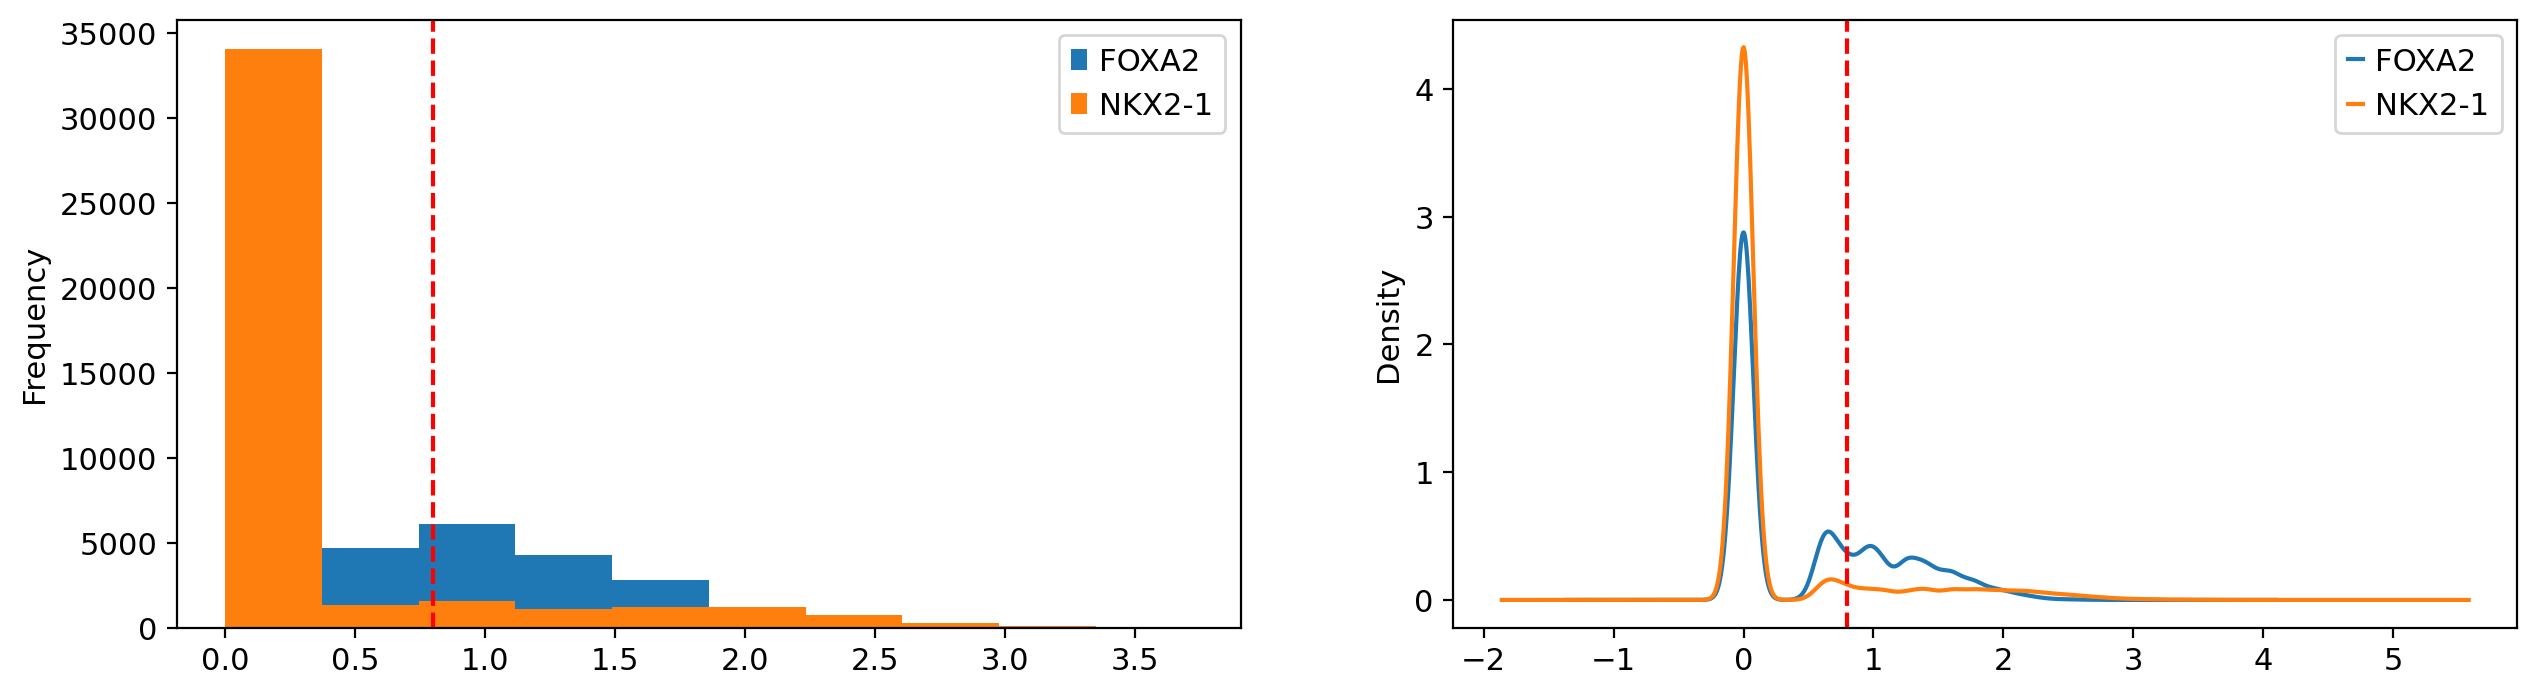

In [89]:
df = all_mistr[:, ['FOXA2', 'NKX2-1']].to_df()
fig, ax = plt.subplots(1, 2, figsize=[15, 4])

df.plot.hist(ax=ax[0])
ax[0].axvline(x=0.8, c='r', linestyle='--')

df.plot.kde(ax=ax[1])
ax[1].axvline(x=0.8, c='r', linestyle='--')

In [90]:
df.describe()

FOXA2        NKX2-1
count  41625.000000  41625.000000
mean       0.516328      0.266928
std        0.630920      0.633633
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.980781      0.000000
max        2.733623      3.720216

In [91]:
##########subset cells expressing FOXA2 and NKX2-1#######
mistr_subset = subset_two_genes2(all_mistr, gene1 = 'FOXA2',gene2 = 'NKX2-1', coexpressed=False)
mistr_subset.shape

(17641, 21923)

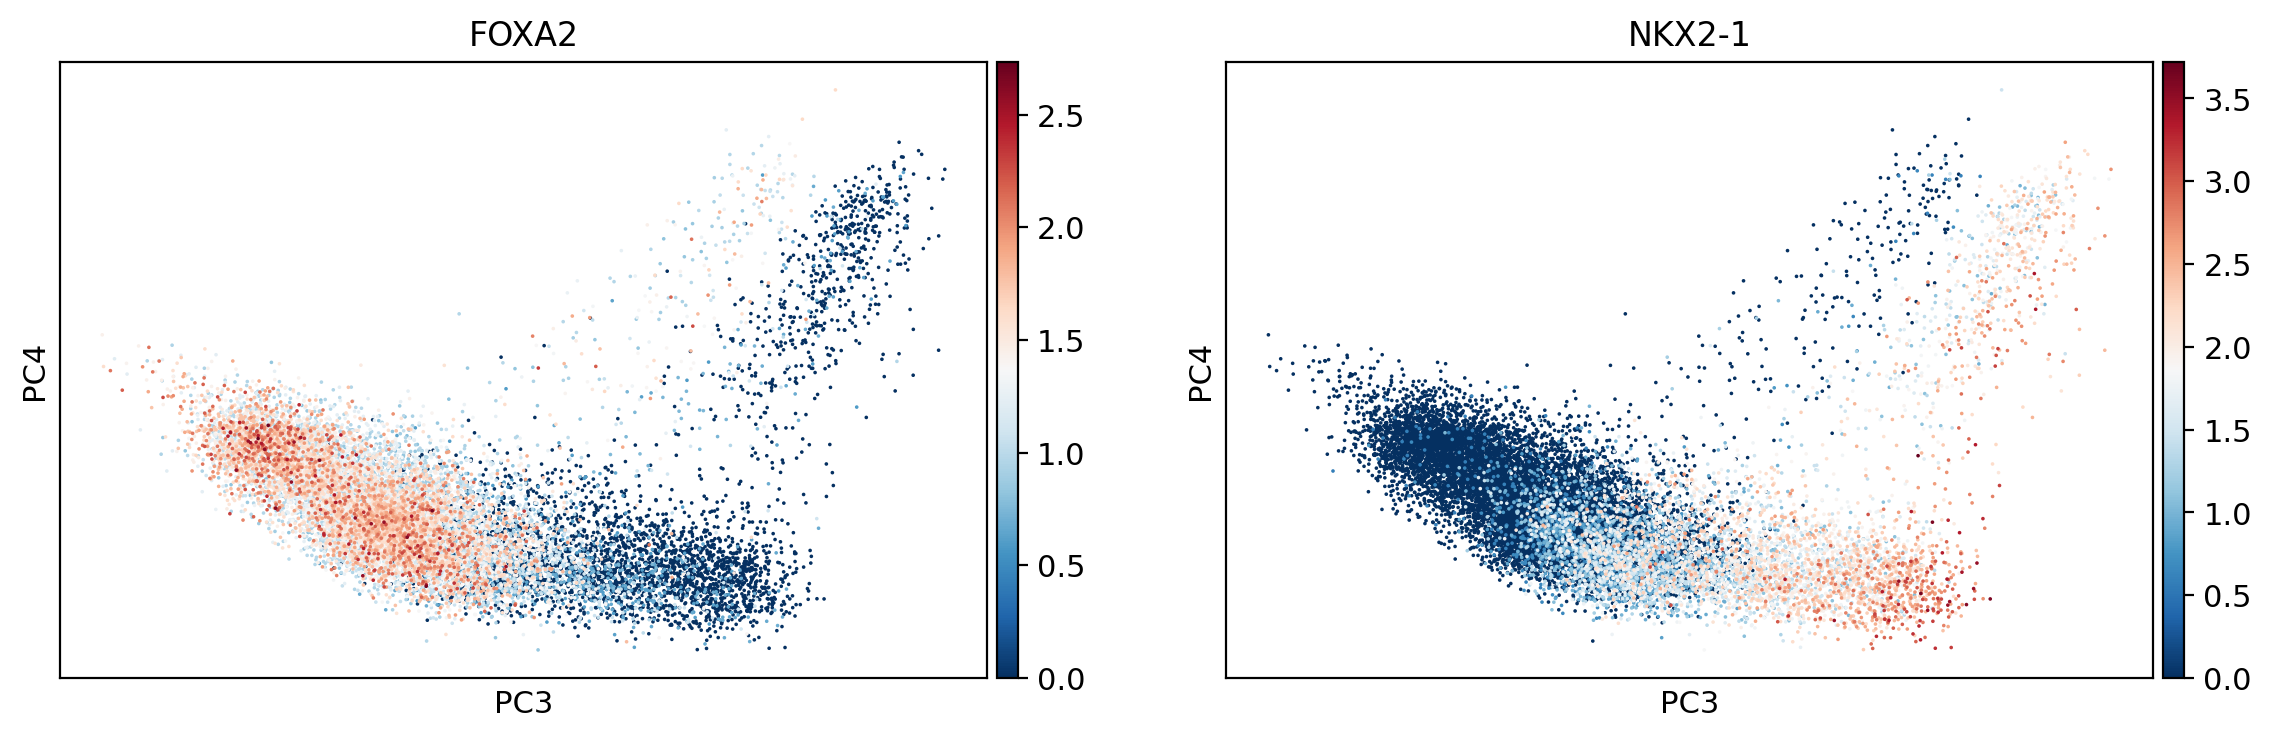

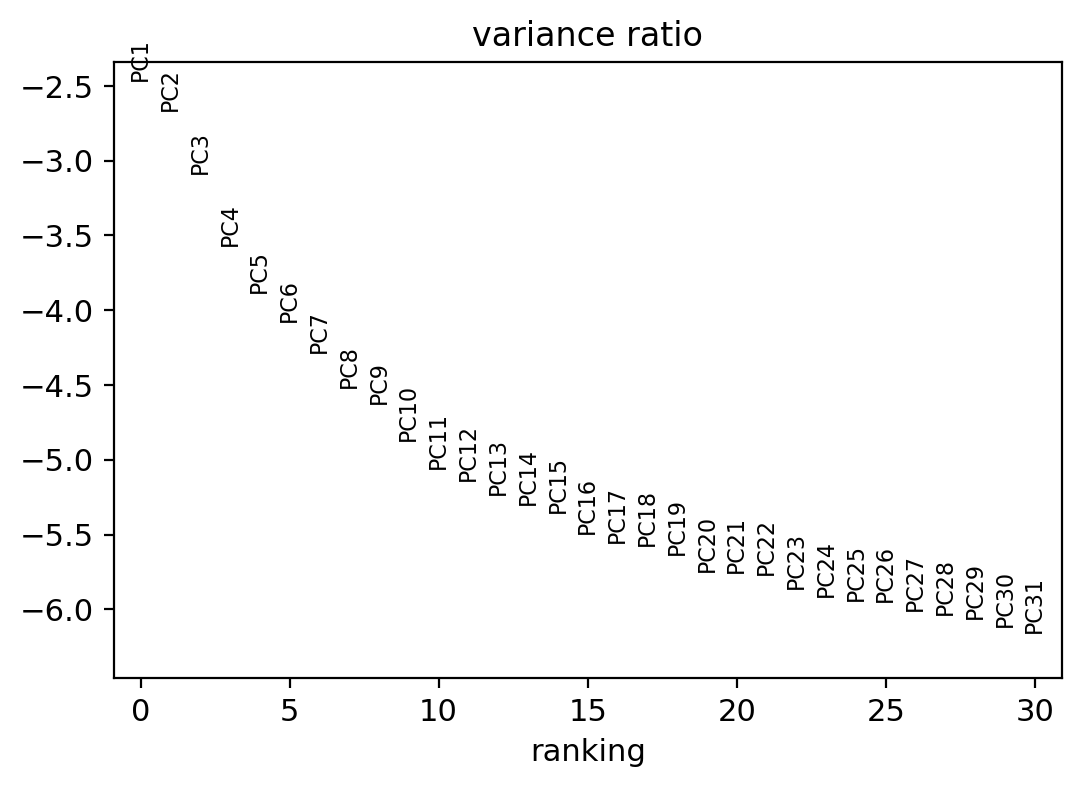

In [92]:
################perform PCA and pc elbow plot ################
sc.tl.pca(mistr_subset, svd_solver = 'arpack', use_highly_variable = True)
sc.pl.pca(mistr_subset, components = ['3,4'], ncols=2, color = ['FOXA2','NKX2-1'])
sc.pl.pca_variance_ratio(mistr_subset, log=True)

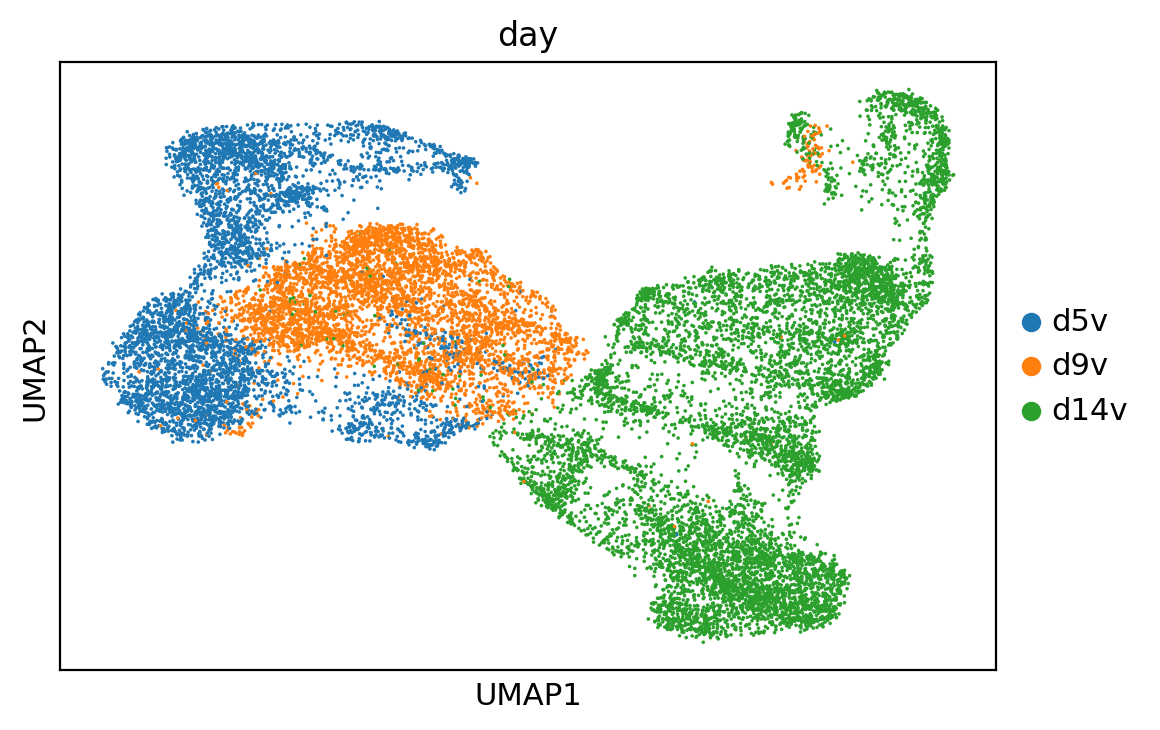

In [93]:
sc.pp.neighbors(mistr_subset, n_neighbors=20, n_pcs=35)
sc.tl.umap(mistr_subset)
sc.pl.umap(mistr_subset, color = ['day'], wspace= 0.5)

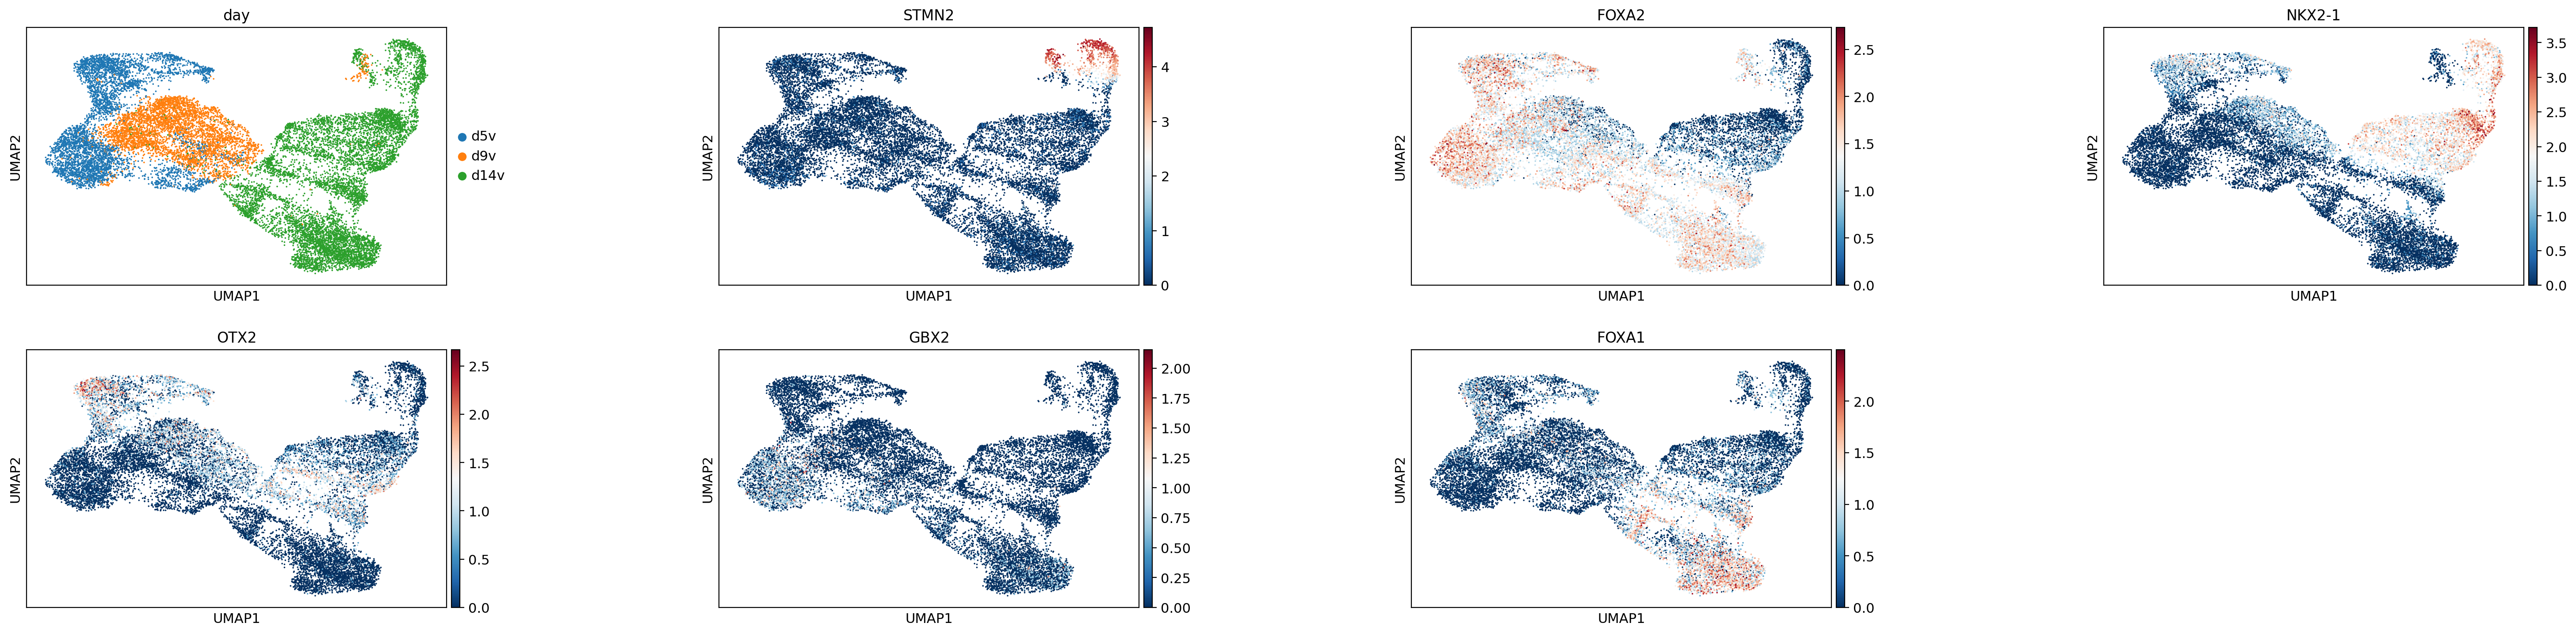

In [94]:
sc.pl.umap(mistr_subset, color = ['day','STMN2','FOXA2','NKX2-1','OTX2','GBX2','FOXA1'], wspace= 0.5)

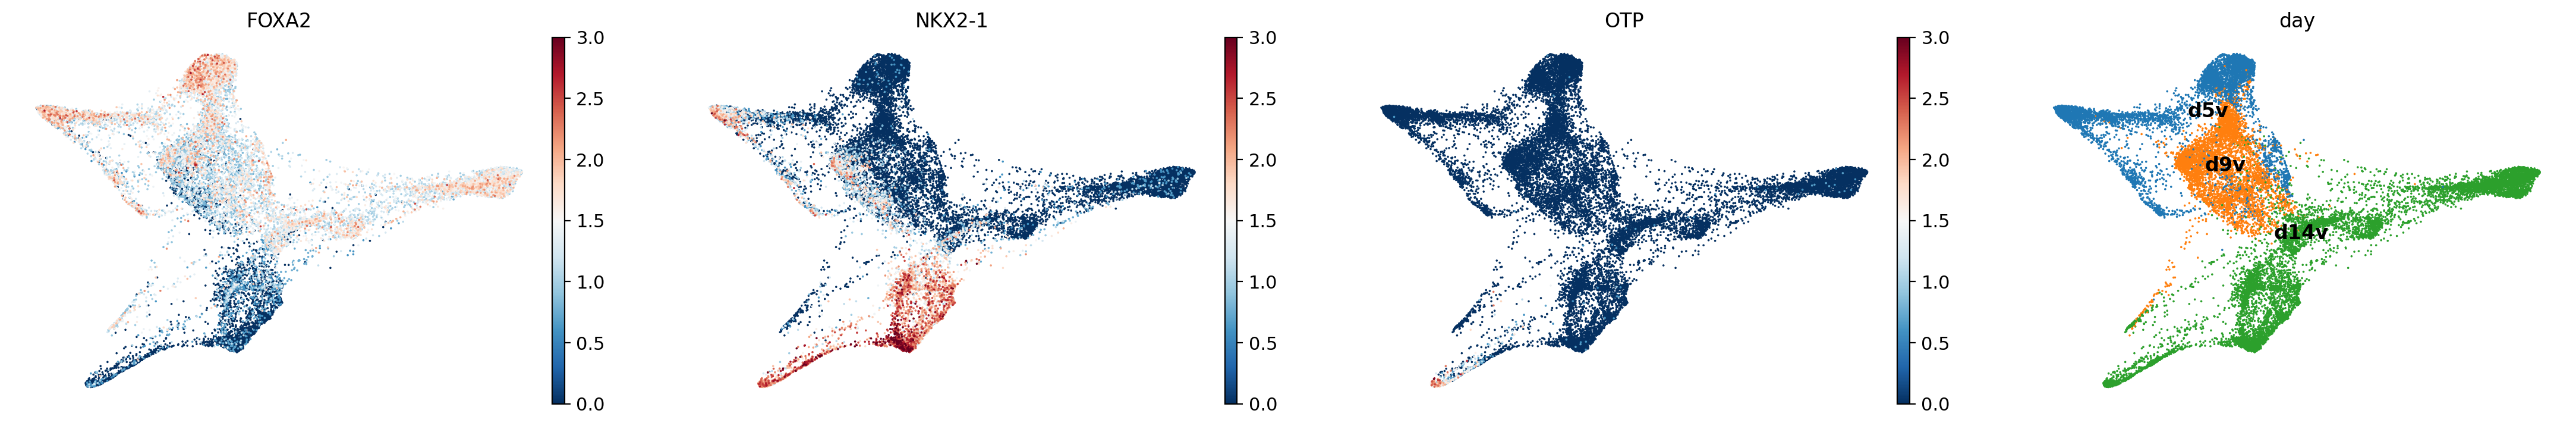

In [95]:
sc.tl.draw_graph(mistr_subset, random_state=2,n_jobs=10)
sc.pl.draw_graph(mistr_subset, color=['FOXA2','NKX2-1','OTP','day'],frameon=False, legend_loc='on data', vmax = 3)

In [96]:
FOXA2_cell_names = mistr_subset[mistr_subset[: , 'FOXA2'].X > 0, :].obs_names
NKX2_1_cell_names = mistr_subset[mistr_subset[: , 'NKX2-1'].X > 0, :].obs_names
common_obs = np.intersect1d(FOXA2_cell_names, NKX2_1_cell_names)

In [97]:
mistr_subset.obs['cluster'] = 'xyz'
mistr_subset.obs.loc[FOXA2_cell_names,"cluster"] = 'FOXA2'
mistr_subset.obs.loc[NKX2_1_cell_names,"cluster"] = 'NKX2-1'
mistr_subset.obs.loc[common_obs,"cluster"] = 'co-expressed'
#adata.obs.loc[~FOXA2_cell_names] = 'FOXA2'

In [98]:
mistr_subset.uns['iroot'] = np.flatnonzero(mistr_subset.obs['annotations']  == 'd5_Presumptive Ventral Forebrain 2')[0]
sc.tl.dpt(mistr_subset)

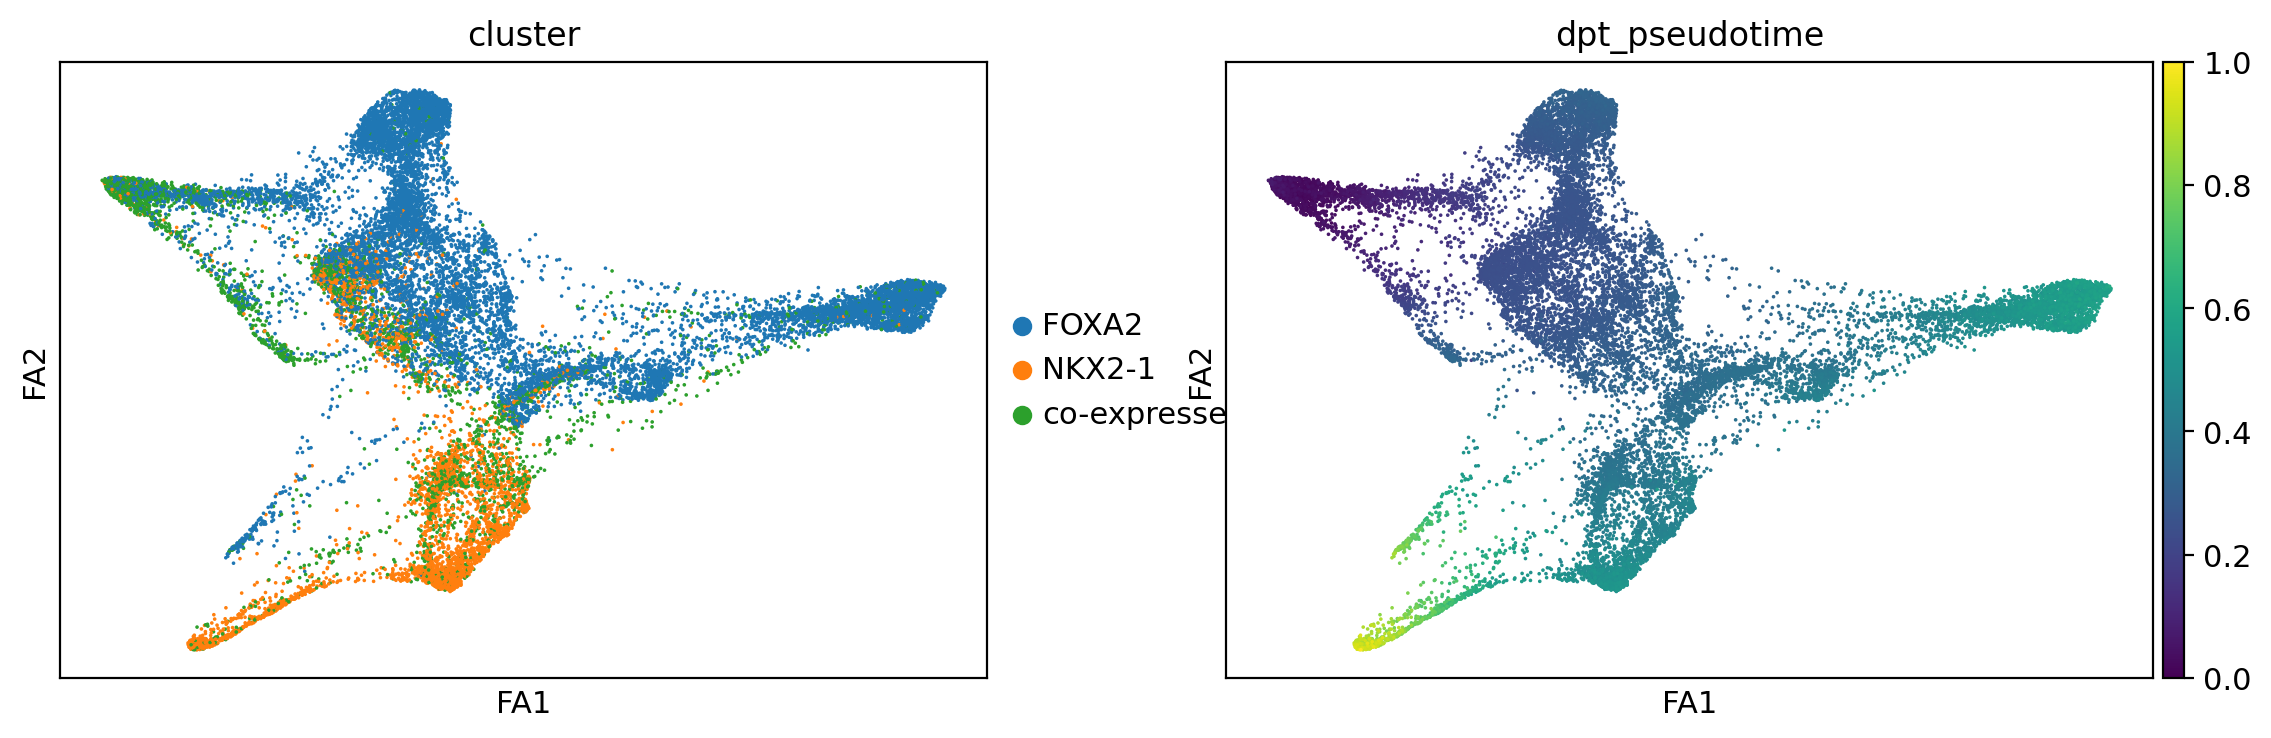

In [99]:
sc.pl.draw_graph(mistr_subset, color = ['cluster','dpt_pseudotime'], color_map='viridis')

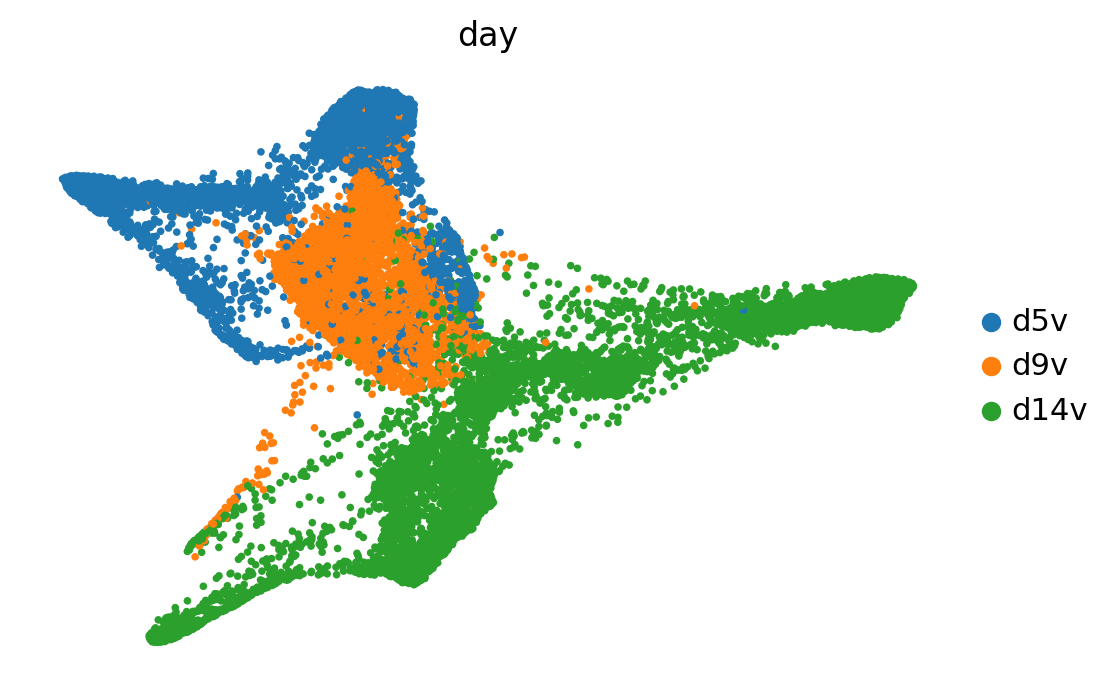

In [113]:
sc.pl.draw_graph(mistr_subset, color = 'day',size = 20,frameon=False ,save= "NKX2-1_FOXA2_subset_day.svg")

In [100]:
#### save adata for further analysis ####
#mistr_subset.write('mistr_day5-14_nf.h5ad')

In [102]:
mistr_subset.obs.groupby(['cluster','day']).apply(len)

cluster       day 
FOXA2         d5v     3673
              d9v     3168
              d14v    4291
NKX2-1        d5v       89
              d9v      571
              d14v    2715
co-expressed  d5v     1141
              d9v      597
              d14v    1396
dtype: int64

In [111]:
adata2 = mistr_subset.copy

In [14]:
adata2 = sc.read_h5ad('mistr_day5-14_nf.h5ad')

In [15]:
CellCycleRegression(adata2)

Regressing individual phases
Regressed
[[-1.66596435e-02  5.71827650e-01 -1.74592599e-01 -1.68868467e-01
  -7.21924126e-01 -5.21897823e-02 -1.21027015e-01 -6.89779282e-01
  -2.64334202e-01 -6.02820516e-01]
 [-2.64900960e-02  1.42243505e+00 -1.25447899e-01 -1.88042089e-01
   1.19207215e+00 -1.77829154e-02 -1.32586673e-01 -5.52919924e-01
  -1.85324624e-01 -5.25953054e-01]
 [-2.65949704e-02 -9.29169476e-01 -1.24923617e-01 -1.88246638e-01
  -4.57894504e-01 -1.74158532e-02 -1.32709980e-01  9.72297430e-01
  -1.84481740e-01  1.26315963e+00]
 [ 2.82673340e-04  6.97734773e-01 -2.59291112e-01 -1.35823637e-01
   1.84730077e+00 -1.11488380e-01 -1.01104505e-01  5.49330354e-01
  -4.00503397e-01 -7.35297799e-01]
 [-1.28775286e-02  9.87661302e-01 -1.93500265e-01 -1.61491722e-01
   2.20819163e+00 -6.54272959e-02 -1.16579615e-01 -7.42433786e-01
  -2.94731885e-01 -6.32394016e-01]
 [-2.39100326e-02  5.61429143e-01 -1.38346240e-01 -1.83009848e-01
   1.10187161e+00 -2.68132128e-02 -1.29552767e-01  1.0646848

AnnData object with n_obs × n_vars = 17641 × 21923
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'annotations', 'Subclass', 'day', 'Age', 'SCT_snn_res.0.6', 'batch', 'n_genes', 'cluster', 'dpt_pseudotime', 'S_score', 'G2M_score', 'phase', 'OldPhase'
    var: 'highly_variable', 'gene_ids', 'feature_types', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cluster_colors', 'day_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'iroot', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [16]:
sc.pp.log1p(adata2)

In [17]:
sc.tl.louvain(adata2, resolution = 0.4)

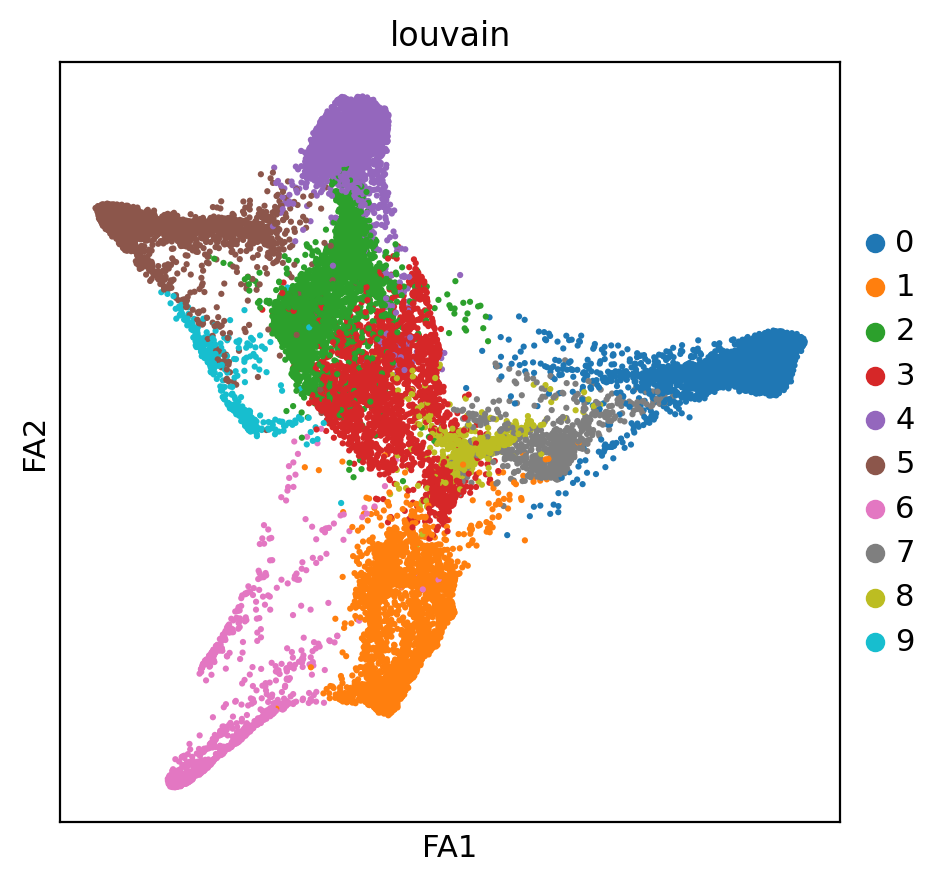

In [26]:
with plt.rc_context({"figure.figsize": [5, 5]}):
    sc.pl.draw_graph(adata2,size = 20 ,color = 'louvain')

In [19]:
sc.tl.rank_genes_groups(adata2, 'louvain', method='wilcoxon', key_added = "wilcoxon")

In [85]:
df = sc.get.rank_genes_groups_df(adata2,key = 'wilcoxon',group = None )
df.head(50)

group       names     scores  logfoldchanges  pvals  pvals_adj
0      0       CMTM8  78.238152             NaN    0.0        0.0
1      0         ARX  71.653625             NaN    0.0        0.0
2      0        CD47  70.554443             NaN    0.0        0.0
3      0         SHH  69.276367             NaN    0.0        0.0
4      0       ALCAM  63.625019             NaN    0.0        0.0
..   ...         ...        ...             ...    ...        ...
45     0       LYVE1  49.577347       -0.190517    0.0        0.0
46     0  PABPC4-AS1  49.574036       -0.617750    0.0        0.0
47     0  AC087427.1  49.572418       -0.600442    0.0        0.0
48     0  AC093503.1  49.569630       -0.476557    0.0        0.0
49     0     GALNTL6  49.567833       -1.105814    0.0        0.0

[50 rows x 6 columns]

In [86]:
sc.tl.rank_genes_groups(adata2, 'louvain',n_genes = 100, method='t-test',key_added = "t-test")
df  = pd.DataFrame(adata2.uns['t-test']['names'])
df.head(20)

0               1           2           3        4        5  \
0       SHH            SIX3   LINC01198       TTC9B   ATP1A2   SHISA2   
1       ARX           SFTA3       WFDC2         OTP     FZD7     STOM   
2      NTN1       LINC01833        LFNG     NEUROD1     ZIC3      OGT   
3     ALCAM            FZD5       HYMAI        ST18    NRXN3   SEMA3E   
4     RAI14            SIX6       RGS10       NHLH1    FOXB1     FZD5   
5     CNIH2      KC877982.1     FAM107A       STMN2      MN1   PTPN13   
6    METRNL  AUXG01000058.1        OTX1      ACTL6B   RNF220   NKX2-8   
7     SLIT2            LHX2     LRRC75A       AMER3     TNS3    FOXB1   
8      CCN2             RAX         LPL  AC083843.1   SPOCK2     DMKN   
9     FOXA1           CAPN6  AL359504.2       CAPSL      DSP    PKDCC   
10    MMRN1          IGFBP3        LIX1  AL121827.1   PLAGL1   SEMA6A   
11      TTR        SIX3-AS1       CXCL5      CDK5R2    APOC1    CECR2   
12    RAMP1          MPPED2         NGB    DLX6-AS1      SP5     PMEL   
13   PCSK1N        MIR7-3HG  ZNF436-AS1  AP000894.2    KLHL4  SOX2-OT   
14  NECTIN3           HTR2C        BCAM  AC012494.1     UTRN      GSC   
15   IQGAP2            VAX1      OR7A17  AL355482.1     ZIC2    RBPMS   
16    ANXA6           DACH1       LAMP5        ISL1  SLC7A11    EPHA4   
17    EFNB3          MPPED1        EMX2       KCNH6   NKX6-2    PAMR1   
18    ENPP2             SHH      STMND1        UNCX      LPL    CAPN6   
19    KCNG1           ACKR3      PLAGL1     ADCYAP1     PMEL     FZD7   

          6        7        8           9  
0    ELAVL4      SHH     SYT4      SEMA6A  
1    ELAVL3      ARX   APCDD1        FZD5  
2     CRMP1    CNIH2      ARX      NKX2-8  
3       DCX     NTN1     CCN2      SHISA2  
4     INSM1    RAI14   DMRTA2       EPHA4  
5     STMN2    FOXA1    SLIT2     SOX2-OT  
6      SCG3   TMEM65     TCIM         DCX  
7    TLCD3B   PCSK1N    WNT5A      CACNG3  
8      DLL3     CCN2  FAM107A        STOM  
9   GADD45G    KCNG1     RMST      DPYSL3  
10    NHLH1    MMRN1    LMX1A  AC083843.1  
11   NKAIN4    EFNB3      DDC       TTC9B  
12    STMN4    ALCAM  SPATS2L  AL355482.1  
13      INA    ENPP2   MUSTN1       AMER3  
14    ARL4D   METRNL    MLLT3        LGR4  
15    STMN3    SLIT1    RSPO2  AC012494.1  
16   KLHL35   CACNG3    PLPP4       C1QL2  
17     ANK2  NECTIN3    FLRT3  AL121827.1  
18    SRRM4    FOXJ1      SHH        SCG2  
19     ST18    RAMP1    FOXA1    MIR137HG

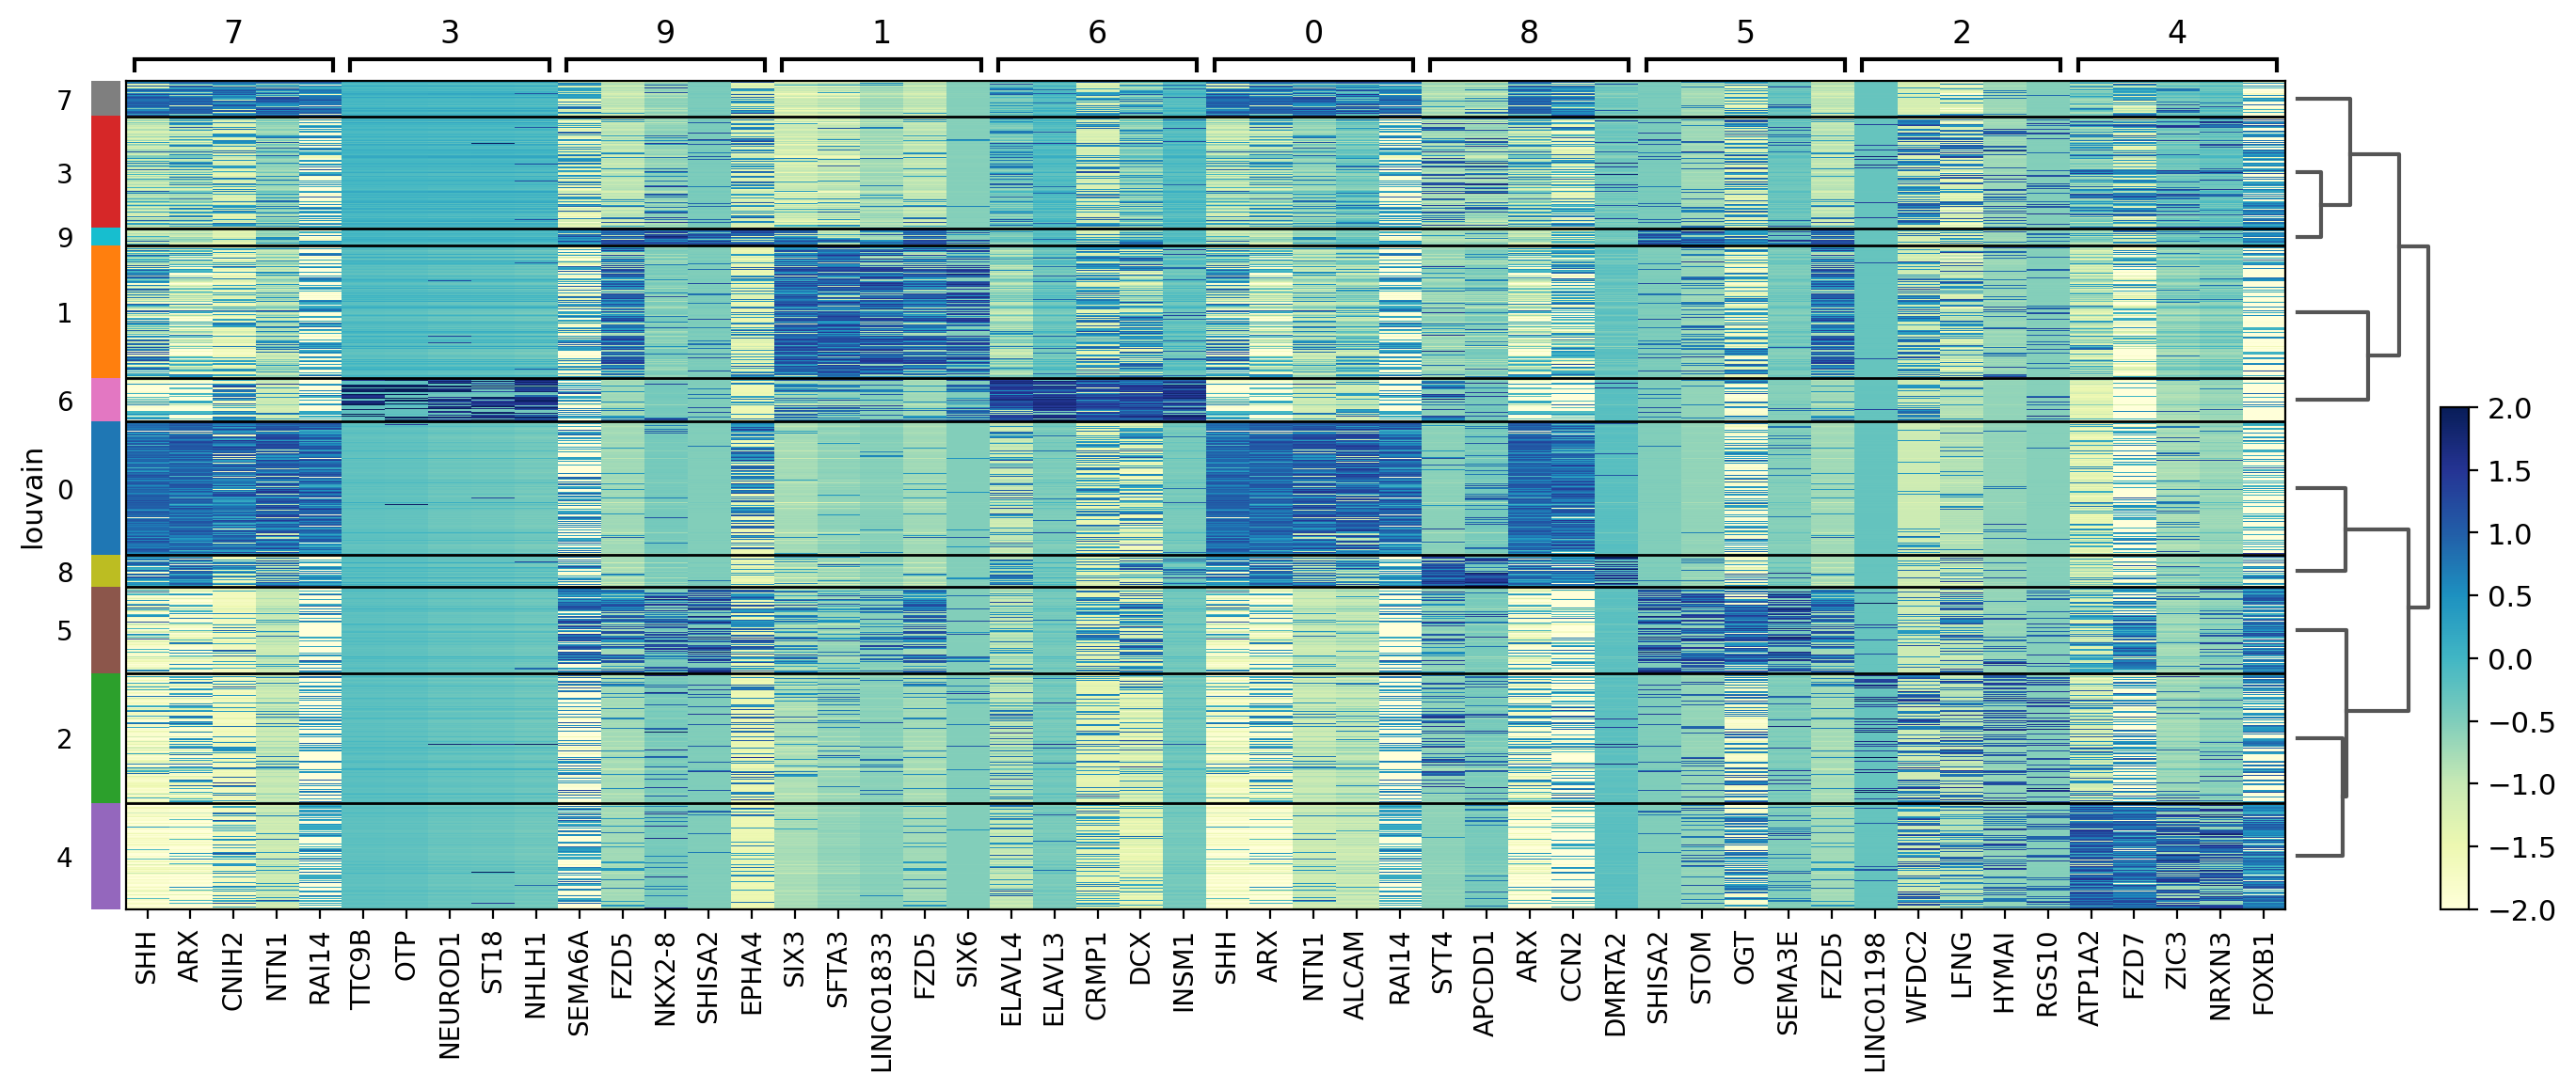

In [24]:
sc.pl.rank_genes_groups_heatmap(adata2, n_genes=5, groupby="louvain",key = 't-test', show_gene_labels=True,vmax = 2, vmin = -2,cmap = "YlGnBu")

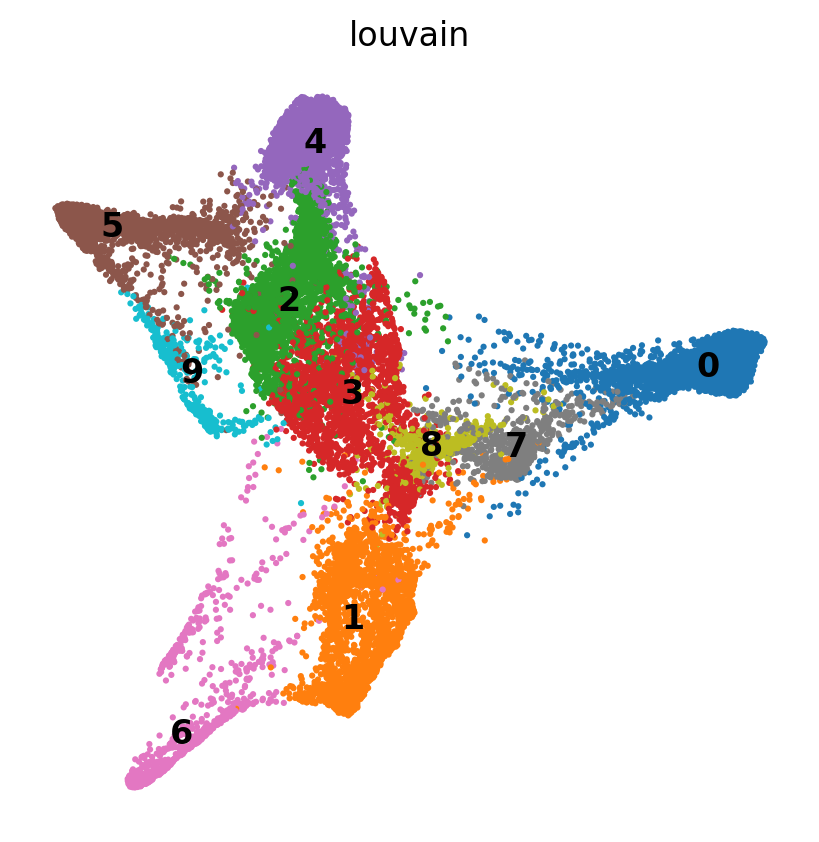

In [27]:
with plt.rc_context({"figure.figsize": [5, 5]}):
    sc.pl.draw_graph(adata2, color = 'louvain',legend_loc='on data',save = "nf_susbset_louvain.svg",frameon=False,size = 20)

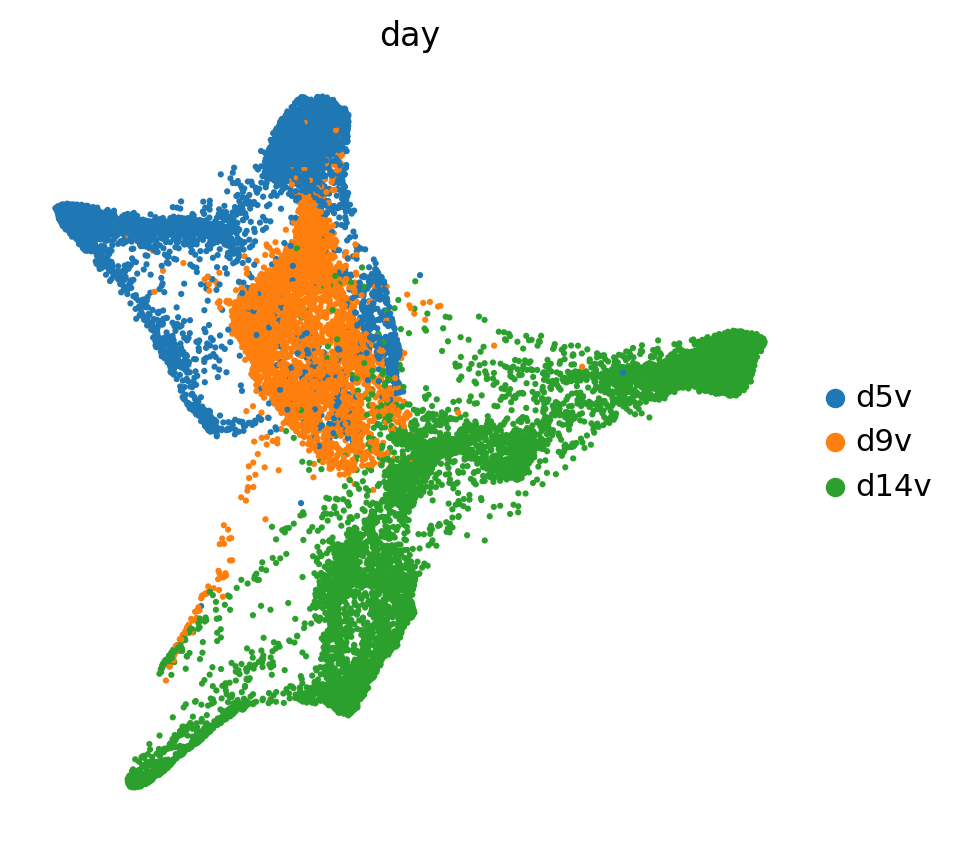

In [36]:
with plt.rc_context({"figure.figsize": [5, 5]}):
    sc.pl.draw_graph(adata2, color = 'day',size = 20,frameon=False ,save= "NKX2-1_FOXA2_subset_day.svg")

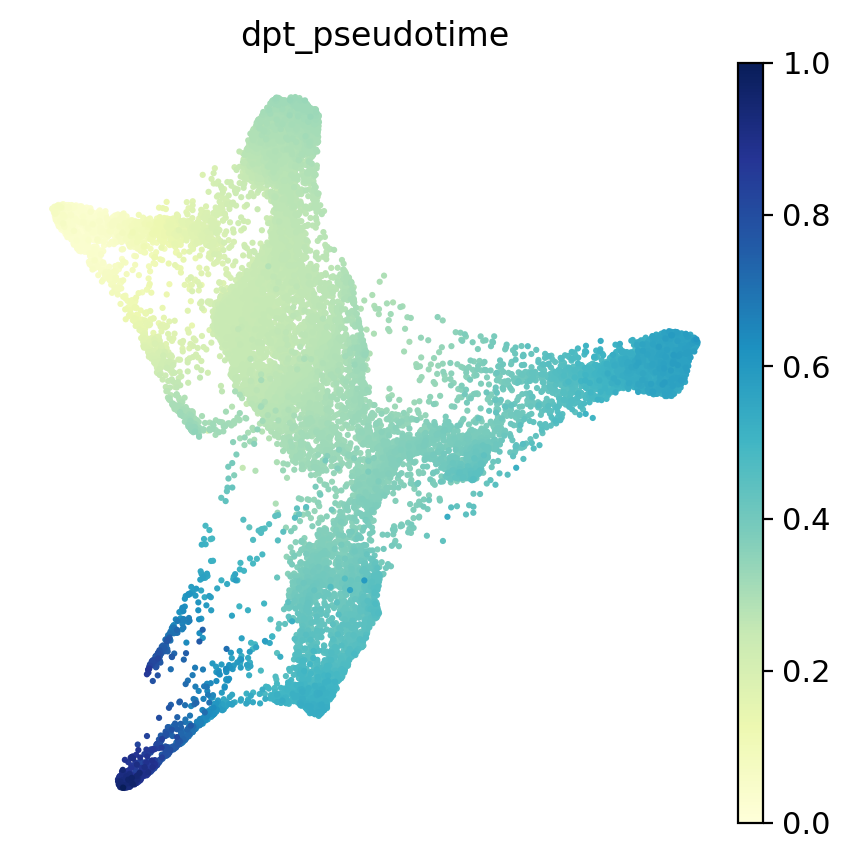

In [37]:
with plt.rc_context({"figure.figsize": [5, 5]}):
    sc.pl.draw_graph(adata2, color = 'dpt_pseudotime',size = 20,color_map='YlGnBu',frameon=False ,save = "nf_susbset_pseudotime.svg")

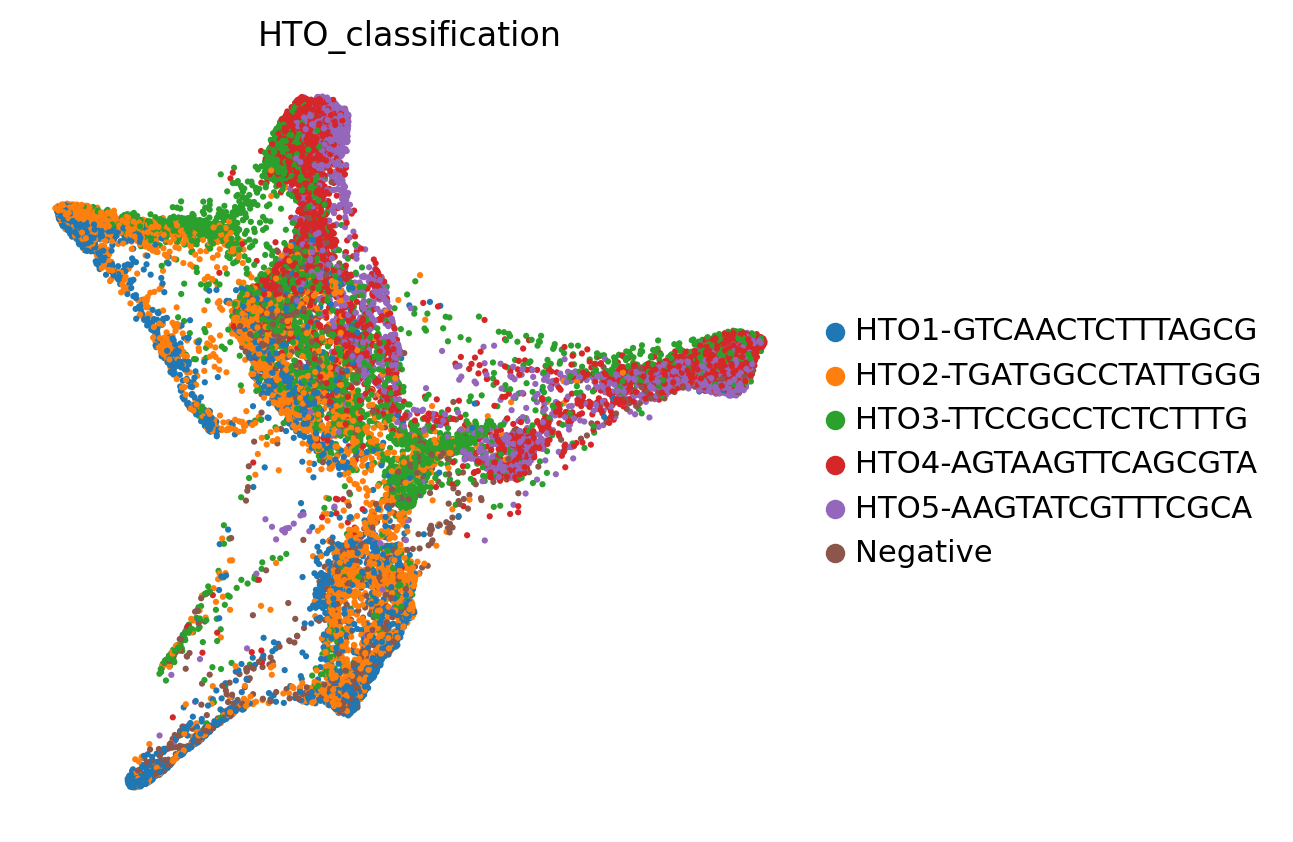

In [38]:
with plt.rc_context({"figure.figsize": [5, 5]}):
    sc.pl.draw_graph(adata2, color = ['HTO_classification'], size = 20,save = "nf_susbset_hashtags.svg",vmin = 0 ,frameon= False )

In [45]:
### save some. gene plots 

In [48]:
####save adata for future reference 

In [49]:
#adata2.write('mistr_day5-14_nf_clustered.h5ad')

In [88]:
df.to_csv('top_markers_ventral_NKX_FOXA2_cluster.csv')